In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# pretty print matrix A
def pprint(A, precision=2):
    A = np.around(A, decimals=precision)
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA) +' '*(w1-len(str(AAA))+1),end='') # str(AAA)
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='') # str(AA[-1])
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

In [128]:
class BaseModel:
    def plot_kernel_(self, kernel, range, step_size):
        r = np.arange(0,range,step_size)
        if kernel == 'eta':
            plt.plot(r,self.eta_kernel(r))
            plt.axhline(0, linestyle='--', color='gray')
        elif kernel == 'eps':
            plt.plot(r, self.eps_kernel(r))
            plt.axhline(0, linestyle='--', color='gray')
            plt.axhline(1, linestyle='--', color='gray')
        else:
            raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
    def show_epsilon_matrix_(self, size):
        def print_epsilon_matrix(matrix):
            max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
            column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
            for row in matrix:
                print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
        matrix = np.empty((2,size), dtype='U40')

        for i in range(size):
            matrix[0, i] = f'epsilon({size-i}ms)'
            matrix[1, i] = self.eps_kernel((size-i)*self.dt)
        print_epsilon_matrix(matrix)
    
    def plot_membrain_potential_(self):
        plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
        if len(self.spike_rec)>0:
            for spk in self.spike_rec:
                plt.axvline(spk/self.dt, linestyle='--', color='gray')
        plt.axhline(self.threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')


class SRM(BaseModel):
    def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, verbose=True) -> None:
        """_summary_

        Args:
            threshold (_type_): _description_
            tau_m (_type_): _description_
            tau_s (_type_): _description_
            K (_type_): _description_
            K1 (_type_): _description_
            K2 (_type_): _description_
            window_size (_type_): _description_
            verbose (bool, optional): _description_. Defaults to True.
        """

        self.threshold = threshold
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.dt = dt
        self.window_size = window_size
        self.tref = tref
        self.verbose = verbose 
        # TODO: use history to store spike_rec and potential_rec?
        self.last_spike_time = -1000.000 # seocnd

        self.history = {}

    def find_K(self):
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        self.K = 1 / max_val

    def eps_kernel(self, s):
        '''
        s = t - t_j 
        time difference between current time and spike time of presynaptic neuron (t_j)
        '''
        # K = find_max_and_K(tau_m,tau_s) # k defined in formual of epsilon in the paper
        # Choose K such that the maximum value of epsilon kernel will be 1.
        if not hasattr(self, 'K'):
            self.find_K()
        return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
    def eta_kernel(self, s):
        # TODO: figure out if T is actually the threshold value
        T = self.threshold
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return T * (positive_pulse - negative_spike_afterpotential)
    
    def create_epsilon_matrix(self, spike_train):
        matrix = np.zeros(spike_train.shape)
        if spike_train.ndim ==1:
            size = len(spike_train)
            for it in np.arange(size):
                matrix[it] = self.eps_kernel((size-it)*self.dt)
        else:
            size = spike_train.shape[1]
            for it in np.arange(size):
                matrix[:, it] = self.eps_kernel((size-it)*self.dt)
        return matrix
    
    


    def run(self, spike_train, weight,):
        n, total_length = spike_train.shape
        self.spike_rec = []
        self.potential_rec = [0]
        ref_counter = 0
        self.last_spike_time = -100000 # reseting last_spike_time
        for it in range(total_length):           
            t = it*self.dt

            if ref_counter > 0:
                print('*** this is a refractory phase ***')
                ref_counter -= 1
            elif self.potential_rec[-1] > self.threshold:
                print('*** Membrain potential above threshold ***')
                # we spike
                # if at 3ms the inputs make the post- go above the threshold
                # then post-synaptic neuron will spike at 4ms (next time step)
                # is it correct? why? 
                self.last_spike_time = t # ms
                self.spike_rec.append(t) # time in ms
                # spike_rec[it+1] = 1 # not using this method anymore!
                ref_counter = (self.tref)/self.dt
            
            
            start_widnow = max(0, it+1-self.window_size, int(self.last_spike_time/self.dt))
            end_window = it + 1
            spike_train_window = spike_train[:, start_widnow:end_window]
            epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
            eps = spike_train_window * epsilon_matrix
            eps = np.sum(eps, axis=1, keepdims=True)
            eps = eps * weight
            eps = np.sum(eps)
            eta = self.eta_kernel(t-self.last_spike_time)
            potential = eta + eps
            self.potential_rec.append(potential)
        
            if self.verbose:
                print(f't = {it}ms, {t}')
                pprint(spike_train_window)
                print(self.spike_rec)
                pprint(self.potential_rec)
                print(f't-last_spike_post: {t}-{self.last_spike_time} = {t-self.last_spike_time}')
                print(f'duplicate eta: eta(t-last_spike_post) = {self.eta_kernel(t-self.last_spike_time)}')
                print(f'eta = {eta}')
                print(f'potential = {potential}')
                print(f'//////// end {it}ms ////////\n')


        self.spike_rec = np.array(self.spike_rec)
        self.potential_rec = np.array(self.potential_rec)
    
    

In [129]:
test = SRM(threshold=2.9, tau_m=0.010, tau_s=0.0025, K1=2, K2=4, dt=0.001, window_size=1000, tref=0.001, verbose=False)

In [130]:
# spike_train = np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                        # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=int)
####### like in the paper fig.3 
spike_train = np.zeros((2,75))
spike_train[0, [2,23,44]] = 1
spike_train[1, [45,48,61]] = 1
# spike_train[0, 2] = 1
####################################

weight = np.array([1,1], dtype=float).reshape(-1,1)

test.run(spike_train, weight)

*** Membrain potential above threshold ***
*** this is a refractory phase ***


(2.908342453265573, 5.8)

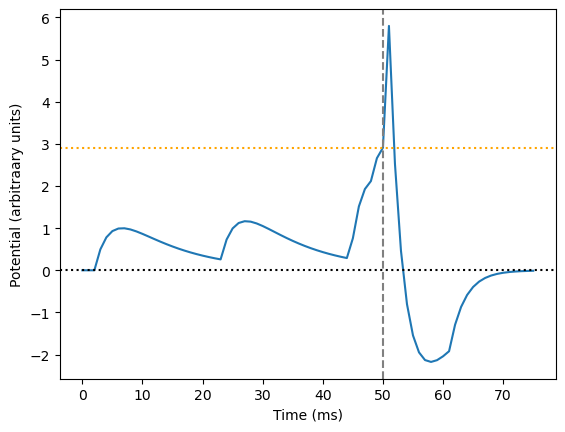

In [131]:
test.plot_membrain_potential_()
test.potential_rec[50], test.potential_rec[51]

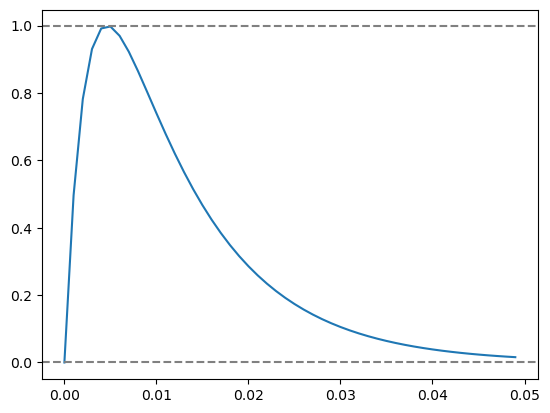

In [136]:
test.plot_kernel_('eps', 0.05, 0.001)

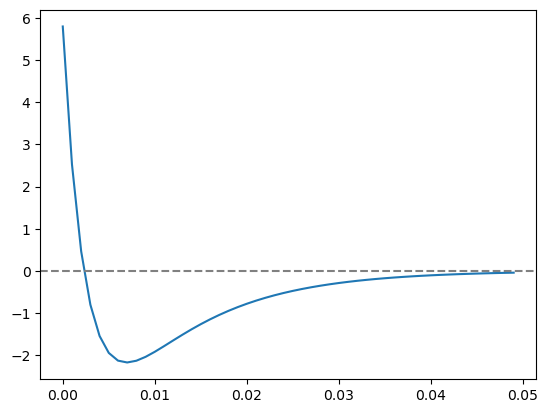

In [138]:
test.plot_kernel_('eta', 0.05, 0.001)

In [107]:
def find_max_and_K(tau_m, tau_s):
    # Find the maximum value of epsilon_func
    s_max = (tau_m * tau_s) / (tau_s - tau_m) * np.log(tau_s / tau_m)
    max_val = (np.exp(-s_max/tau_m) - np.exp(-s_max/tau_s))
    K = 1 / max_val
    return K

def epsilon_func(s):    
    '''
    s = t - t_j 
    time difference between current time and spike time of neuron 1 (t_j)
    '''
    # K = find_max_and_K(tau_m,tau_s) # k defined in formual of epsilon in the paper
    # Choose K such that the maximum value of epsilon kernel will be 1.
    
    return K * (np.exp(-s/tau_m) - np.exp(-s/tau_s))

def eta_func(s):
    positive_pulse = K1 * np.exp(-s/tau_m)
    negative_spike_afterpotential = K2 * (np.exp(-s/tau_m) - np.exp(-s/tau_s))
    return T * (positive_pulse - negative_spike_afterpotential)

In [4]:
def create_epsilon_matrix(spike_train):
    matrix = np.zeros(spike_train.shape)
    if spike_train.ndim ==1:
        size = len(spike_train)
        for it in np.arange(size):
            matrix[it] = epsilon_func((size-it)*dt)
    else:
        size = spike_train.shape[1]
        for it in np.arange(size):
            matrix[:, it] = epsilon_func((size-it)*dt)
    return matrix

In [5]:
def show_epsilon_matrix(size):
    # matrix = np.array([num_neurons, size], dtype='<U6')
    dt = 0.001
    matrix = np.empty((2,size), dtype='U20')

    for i in range(size):
        matrix[0, i] = f'epsilon({size-i}ms)'
        matrix[1, i] = epsilon_func((size-i)*dt)
    return matrix

In [6]:
def plot_kernel(range, kernel):
    r = np.arange(0,range,0.0005)
    plt.plot(r,kernel(r))

## Just membrain potential calculation

Let's construct one presynaptic neuron (neuron number 1) connected to one postsynaptic ceuron (neuron number 2).

In a discrete time span, create a spike train for neuron 1 as input and see how it effects the membrain potential of neuron 2.

In [7]:
spike_train = np.array([[1,0,0,1,1,1,0,0,0,1]], dtype=int)
weight = np.array([[10]], dtype=float)


spike_rec = np.zeros_like(spike_train, dtype=int)
spike_train_size = spike_train.shape[1]

In [8]:
dt = 0.001
tau_m = 0.010
tau_s = 0.0025

T = 1 # threshold of the neuron! why it is equal to 500 in the paper?
K1 = 2
K2 = 4

calculate membrain potential for neuron 2 based on the 10 spikes (10 time steps i.e. 10 ms) of neuron 1

the last spike of neuron 2 has been long ago.

however in this naive methon maybe neuron 2 has reached to its threshold at time step 4 
so we should not continue adding to membrain potential

based on the effect of up coming spikes from neuron 1.

neuron 2 should fire, reset its membrain potential, enter refractory phase (later we should do one step of STDP learning rule )

In [9]:
epsilon_matrix = create_epsilon_matrix(spike_train)
eps = epsilon_matrix * spike_train
eps = np.sum(eps)
eta = eta_func(s, K1, K2, tau_m, tau_s)

membrain_potential = eps + eta
membrain_potential

NameError: name 'K' is not defined

## Adding more features
Now we have two presynaptic neurons (neuron 1 and 2) and one postsynaptic neuron 3. 
neuron 1 and 2 are connected to neuron 3 with synaptic weights equal to 10 and 20 respectively.

the model should go through all the input spike train one step at a time (one time step) to check 
if the neuron 2 has been reached to its threshold or not. if so do the steps below:

- `reset membrain potential`
- ...
- ...
- ... 

In [7]:
# spike_train = np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                        # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=int)
####### like in the paper fig.3 
spike_train = np.zeros((2,75))
spike_train[0, [2,23,44]] = 1
spike_train[1, [45,45,61]] = 1
# spike_train[0, 2] = 1
####################################

n, ind_run_time = spike_train.shape
weight = np.array([1.4,1.3], dtype=float).reshape(n,1)

spike_rec = np.zeros(ind_run_time+1, dtype=int)
potential_rec = np.zeros(ind_run_time, dtype=float)

In [8]:
dt = 0.001 
tau_m = 0.010
tau_s = 0.0025

K = find_max_and_K(tau_m, tau_s)
threshold = 2.9
T = threshold # threshold # threshold of the neuron! why it is equal to 500 in the paper?
K1 = 2
K2 = 4

last_spike_post = -10000 # ms or seconds?
tref = 1 * dt # refractory duration [second]
tref_counter = 0

# TODO: leter on I should implement the spike_window such that
# it considers different time windows explained in the paper.
# those time windows are based on time (ms) not the number of input spikes implemented here. 
spike_window = 1000


In [9]:
eta_func(0), eta_func(0.001), eta_func(0.002)

(5.8, 2.527655509404851, 0.46357761590747554)

In [10]:
for it in range(ind_run_time):
    
    t = it*dt # ms
    start_window, end_window = max(0, it+1-spike_window, int(last_spike_post/dt)), it+1
    spike_train_window = spike_train[:, start_window:end_window]
    epsilon_matrix = create_epsilon_matrix(spike_train_window)
    eps = spike_train_window * epsilon_matrix
    eps = np.sum(eps, axis=1, keepdims=True)
    eps = eps * weight
    eps = np.sum(eps)
    eta = eta_func(t-last_spike_post) 
    potential = eta + eps
    potential_rec[it] = potential

    if tref_counter > 0:
        print('*** this is a refractory phase ***')
        # potential_rec[it] = 0
        tref_counter -= 1
    elif potential > threshold:
        print('*** Membrain potential above threshold ***')
        # we spike
        # if at 3ms the inputs make the post- go above the threshold
        # then post-synaptic neuron will spike at 4ms (next time step)
        # is it correct? why? 
        last_spike_post = t + dt # ms
        # eta_after_spike = eta_func(t-last_spike_post)
        # potential = eta_after_spike + eps # potential immediately after postsynapse firing
        spike_rec[it+1] = 1
        tref_counter = (tref+dt)/dt
    
    

        


    print(f't = {it}ms')
    pprint(spike_train_window)
    pprint(spike_rec)
    pprint(potential_rec)
    print(f't-last_spike_post: {t}-{last_spike_post} = {t-last_spike_post}')
    print(f'duplicate eta: eta(t-last_spike_post) = {eta_func(t-last_spike_post) }')
    print(f'eta = {eta}')
    print(f'potential = {potential}')
    print(f'//////// end {it}ms ////////\n')

    

t = 0ms
┌────┐
 [0.0]
 [0.0]
└────┘
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
t-last_spike_post: 0.0--10000 = 10000.0
duplicate eta: eta(t-last_spike_post) = 0.0
eta = 0.0
potential = 0.0
//////// end 0ms ////////

t = 1ms
┌───────┐
 [0.0 0.0]
 [0.0 0.0]
└───────┘
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
t-las

In [11]:
# spike_rec
# potential_rec

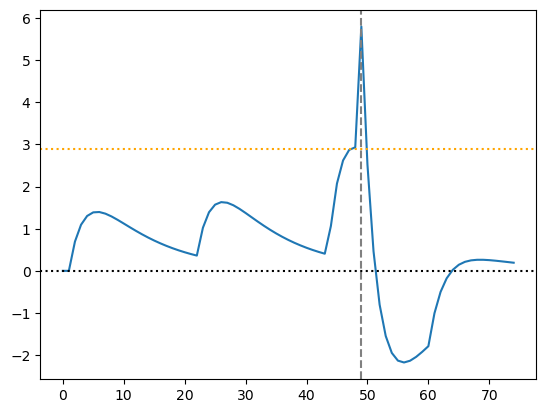

In [12]:
spike_times = np.where(spike_rec == 1)[0]
plt.plot(np.arange(0,ind_run_time,1), potential_rec)
if len(spike_times)>0:
    for spk in spike_times:
        plt.axvline(spk, linestyle='--', color='gray')
plt.axhline(threshold, linestyle='dotted', color='orange')
plt.axhline(0, linestyle='dotted', color='k')

In [44]:
m = show_epsilon_matrix(6)
print(m)

[['epsilon(6ms)' 'epsilon(5ms)' 'epsilon(4ms)' 'epsilon(3ms)'
  'epsilon(2ms)' 'epsilon(1ms)']
 ['0.969571191978708' '0.9973013817341162' '0.9914346682385512'
  '0.9304794853216084' '0.7818517178603276' '0.49636416402416783']]


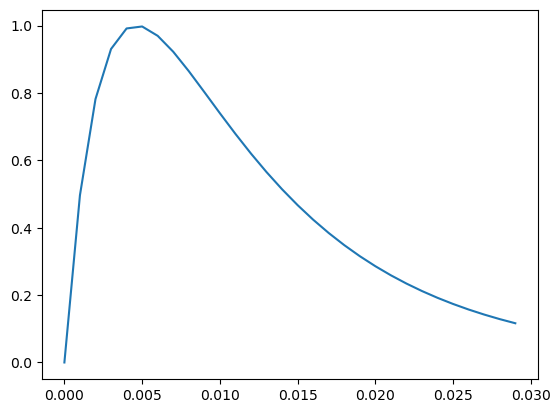

In [22]:
# range 20 [ms]
plot_kernel(0.03, kernel=epsilon_func)

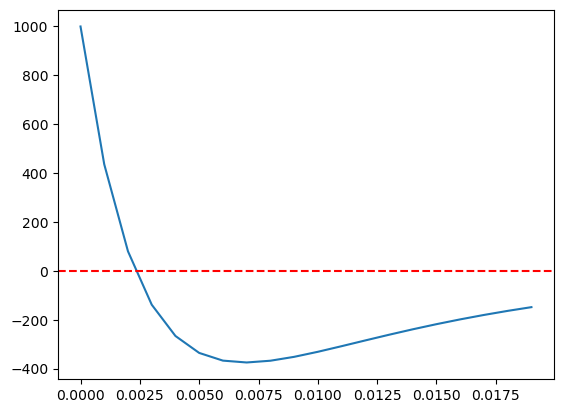

In [23]:
plot_kernel(0.02, kernel=eta_func)
plt.axhline(0, color='r', linestyle = '--')